In [143]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("white")
import warnings
import time

import scipy as sp
import sklearn
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
import tensorflow as tf;

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
learning_curve, ShuffleSplit, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, \
plot_confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning

# Data Loading and Preprocessing

In [30]:
# Import dataset

df_raw = pd.read_csv('esol.csv', sep=",")
df_raw.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [31]:
# Get chemical structures and bioactivities and remove irrelevant columns

df_inp = df_raw[['Compound ID', 'smiles', 'measured log solubility in mols per litre']]
print(df_inp.describe())

       measured log solubility in mols per litre
count                                1128.000000
mean                                   -3.050102
std                                     2.096441
min                                   -11.600000
25%                                    -4.317500
50%                                    -2.860000
75%                                    -1.600000
max                                     1.580000


In [32]:
# Define categories and set cut-off

# Compounds with inhibition index values greater than 1 are considered a hit 

df_inp['Cat'] = df_inp['measured log solubility in mols per litre'].apply(lambda x: 1 if x > -3 else 0) 
df_inp.head()

/anaconda3/envs/CHML/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Compound ID,smiles,measured log solubility in mols per litre,Cat
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,1
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,0
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,1
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,0
4,Thiophene,c1ccsc1,-1.33,1


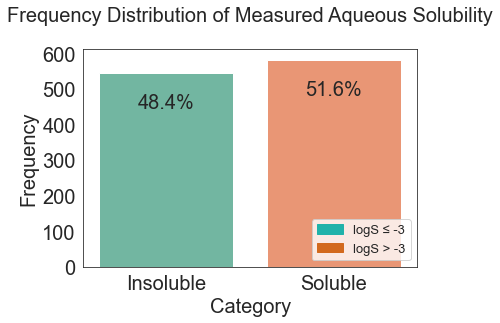

In [33]:
# Plot of data

plot = sns.countplot(x = 'Cat', data = df_inp, palette = 'Set2')
total_count = df_inp.shape[0]
bin_count = df_inp['Cat'].value_counts()
labels = dict(df_inp['Cat'].value_counts())

for k in labels:
    count = labels[k]
    freq = '{:0.1f}%'.format(count/total_count*100)
    plt.text(k, count-100, freq, ha = 'center', fontsize=20)
    
plt.title('Frequency Distribution of Measured Aqueous Solubility\n', fontsize=20)
label1 = mpatches.Patch(color='lightseagreen', label='logS ≤ -3')
label2 = mpatches.Patch(color='chocolate', label='logS > -3')
plt.legend(handles=[label1, label2], fontsize=13, loc=4)
plot.set_xticklabels(['Insoluble','Soluble'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Category', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('ds2_fig1', bbox_inches='tight')

# Feature Generation Based on Chemical Structures

In [34]:
# Remove rows that are missing chemical structures or SMILES

df_inp.dropna(subset=['smiles'], inplace = True)
df_inp

/anaconda3/envs/CHML/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Compound ID,smiles,measured log solubility in mols per litre,Cat
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,1
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.300,0
2,citral,CC(C)=CCCC(C)=CC(=O),-2.060,1
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,0
4,Thiophene,c1ccsc1,-1.330,1
...,...,...,...,...
1123,halothane,FC(F)(F)C(Cl)Br,-1.710,1
1124,Oxamyl,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,1
1125,Thiometon,CCSCCSP(=S)(OC)OC,-3.091,0
1126,2-Methylbutane,CCC(C)C,-3.180,0


# Calculate molecular descriptors

In [35]:
# Calculate molecular descriptors

desc_types = [x[0] for x in Descriptors._descList]

print('There are {} descriptors to be calculated.'.format(len(desc_types)))

def calc_descriptors(smile, desc_type):
    """
    Input: a single SMILES and a single descriptor type
    Output: descriptor for a single chemical structure
    """
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([desc_type]) # Define a descriptor calculator
    
    desc = calc.CalcDescriptors(Chem.MolFromSmiles(smile)) # Calculate descriptor

    return desc[0]

There are 200 descriptors to be calculated.


In [11]:
# Add computed descriptors to existing dataframe as new columns
start = time.time()
for dt in desc_types:
    df_inp[dt] = df_inp.smiles.apply(lambda x: calc_descriptors(x, dt))
end = time.time()
print(f'Training time: {end - start}s')

Training time: 45.924615144729614s


In [36]:
df_inp

,Compound ID,smiles,measured log solubility in mols per litre,Cat
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,1
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.300,0
2,citral,CC(C)=CCCC(C)=CC(=O),-2.060,1
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,0
4,Thiophene,c1ccsc1,-1.330,1
...,...,...,...,...
1123,halothane,FC(F)(F)C(Cl)Br,-1.710,1
1124,Oxamyl,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,1
1125,Thiometon,CCSCCSP(=S)(OC)OC,-3.091,0
1126,2-Methylbutane,CCC(C)C,-3.180,0


In [ ]:
# Export calculated molecular descriptors as .csv

df_inp.to_csv('esol_descriptors.csv')

In [37]:
# Load molecular descriptors as new dataframe

df = pd.read_csv('esol_descriptors.csv')
df.head()

,Unnamed: 0,Compound ID,smiles,measured log solubility in mols per litre,Cat,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,1,10.253329,-1.701605,10.253329,0.486602,0.217518,...,0,0,0,0,0,0,0,0,0,0
1,1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,0,11.724911,-0.145880,11.724911,0.145880,0.811283,...,0,0,0,0,0,0,0,0,0,0
2,2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,1,10.020498,0.845090,10.020498,0.845090,0.343706,...,0,0,0,0,0,0,0,0,0,0
3,3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,0,2.270278,1.301055,2.270278,1.301055,0.291526,...,0,0,0,0,0,0,0,0,0,0
4,4,Thiophene,c1ccsc1,-1.33,1,2.041667,1.712963,2.041667,1.712963,0.448927,...,0,0,0,0,0,0,0,1,0,0



# Calculate molecular fingerprints

,Unnamed: 0,Compound ID,smiles,measured log solubility in mols per litre,Cat,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,ROMol
0,0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,1,10.253329,-1.701605,10.253329,0.486602,0.217518,...,0,0,0,0,0,0,0,0,0,
1,1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,0,11.724911,-0.145880,11.724911,0.145880,0.811283,...,0,0,0,0,0,0,0,0,0,
2,2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,1,10.020498,0.845090,10.020498,0.845090,0.343706,...,0,0,0,0,0,0,0,0,0,
3,3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,0,2.270278,1.301055,2.270278,1.301055,0.291526,...,0,0,0,0,0,0,0,0,0,
4,4,Thiophene,c1ccsc1,-1.33,1,2.041667,1.712963,2.041667,1.712963,0.448927,...,0,0,0,0,0,0,1,0,0,

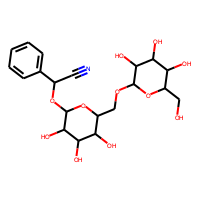
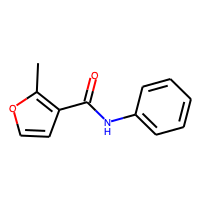
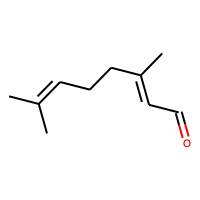
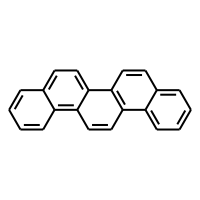
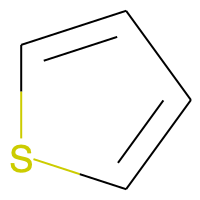

In [38]:
# Generate molecular fingerprint descriptors part 1: convert SMILES to molecular structure

PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
df.head()

In [39]:
# Generate molecular fingerprint descriptors part 2: convert structure to fingerprint vectors

mfp2_fps = rdFingerprintGenerator.GetFPs(list(df['ROMol']))
FPS = []

# Convert fingerprint vectors to numpy arrays

for fp in mfp2_fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    FPS.append(arr)
    
print('There are {} morgan fingerprint bits.'.format(len(FPS[0])))

There are 2048 morgan fingerprint bits.


# Model Building

In [40]:
# Compare performance using two different sets of features

X_desc = df.drop(['Unnamed: 0', 'Compound ID', 'smiles', 'Cat', 'ROMol', 
                  'measured log solubility in mols per litre'], axis = 1)
X_desc.fillna(0, inplace = True)
X_fp = FPS

y = df['Cat']

In [172]:
# Define function to plot learning curves for all algorithms
# Taken from https://scikit-learn.org/stable/_downloads/ea2857380c5e032728a259b30f8e8582/plot_learning_curve.py

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title, fontsize=20)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples", fontsize=20)
    axes[0].set_ylabel("Score", fontsize=20)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring='accuracy',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    print('Accuracy:', round(np.mean(test_scores[-1]), 3))
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc=4, fontsize=14)

    return plt

## Decision Tree Classifier

Accuracy: 0.875


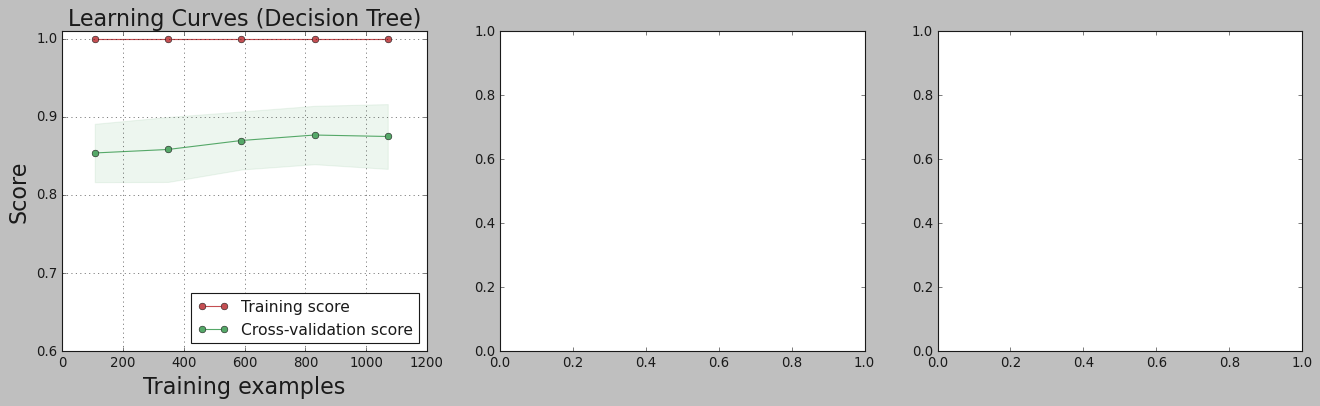

In [196]:
# Plot learning curve for decision tree classifier with default settings
mpl.style.use('classic')
title = "Learning Curves (Decision Tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = DecisionTreeClassifier(random_state=0)
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.6, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds2_tree_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict for decision tree is 0.813s.
Prediction accuracy: 0.877
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       546
           1       0.88      0.88      0.88       582

    accuracy                           0.88      1128
   macro avg       0.88      0.88      0.88      1128
weighted avg       0.88      0.88      0.88      1128



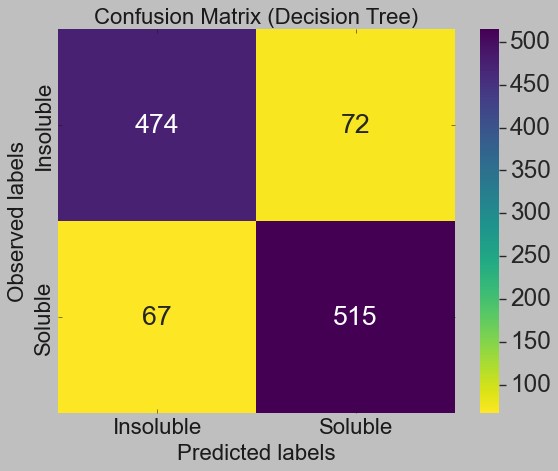

In [156]:
# Initialize the decision tree classifier

tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0)

# Fit the model
start = time.time()
predict = cross_val_predict(tree, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for decision tree is {}s.'.format(round(end - start, 3)))
print('Prediction accuracy:', round(accuracy_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
 
ax.set_xlabel('Predicted labels', fontsize=20);
ax.set_ylabel('Observed labels', fontsize=20);

ax.set_title('Confusion Matrix (Decision Tree)', fontsize=20);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_tree_fig2', bbox_inches='tight')
plt.show()

### Post-pruning

In [64]:
# Decision tree rules
tree = DecisionTreeClassifier(random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_desc, y, test_size=0.20, random_state=0)
tree.fit(X_train, y_train)

tree_rules = export_text(tree, feature_names = list(X_desc.columns))

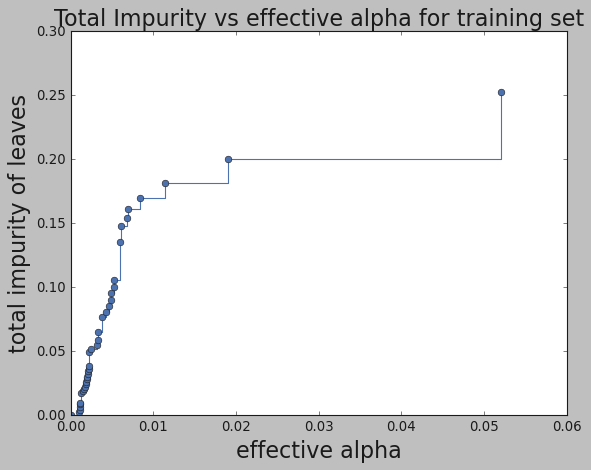

In [75]:
# Implementing cost complexity pruning
mpl.style.use('classic')
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker = 'o', drawstyle = 'steps-post')
ax.set_title('Total Impurity vs effective alpha for training set', fontsize=20)
ax.set_xlabel('effective alpha', fontsize=20)
ax.set_ylabel('total impurity of leaves', fontsize=20);
plt.savefig('ds2_tree_fig3', bbox_inches='tight')

In [76]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    #print('{} nodes with ccp_alpha {}.'.format(tree.tree_.node_count, ccp_alpha))
    
print('Number of nodes in the last tree is: {} with ccp_alpha: {}'.format(trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.247329347139833


In [204]:
best_model.tree_.node_count

9

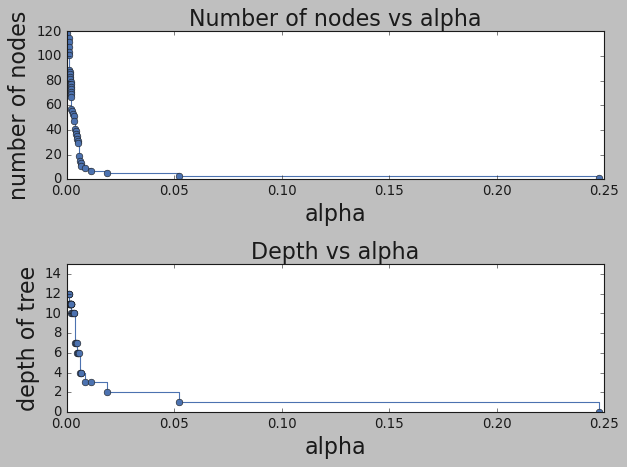

In [77]:
mpl.style.use('classic')

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker = 'o', drawstyle = 'steps-post')
ax[0].set_xlabel("alpha", fontsize=20)
ax[0].set_ylabel("number of nodes", fontsize=20)
ax[0].set_title("Number of nodes vs alpha", fontsize=20)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=20)
ax[1].set_ylabel("depth of tree", fontsize=20)
plt.ylim(0,15)
ax[1].set_title("Depth vs alpha", fontsize=20)
fig.tight_layout()
plt.savefig('ds2_tree_fig4', bbox_inches='tight')

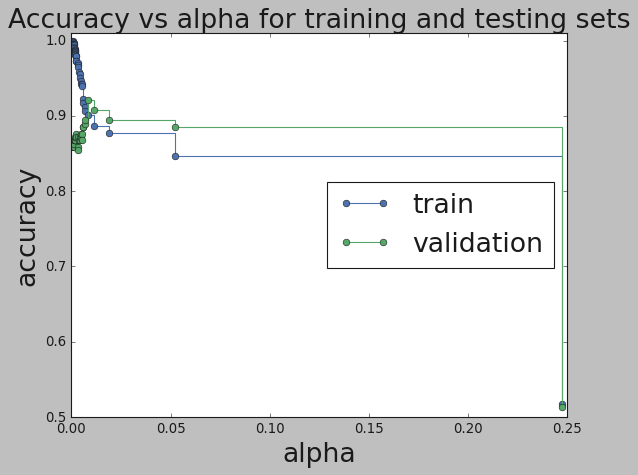

In [81]:
# MC plot: accuracy vs alpha for training and validation
mpl.style.use('classic')
train_scores = [tree.score(X_train, y_train) for tree in trees]
validation_scores = []

for tree in trees:
    predict = tree.predict(X_val)
    validation_scores.append(accuracy_score(y_val, predict))


fig, ax = plt.subplots()
ax.set_title('Accuracy vs alpha for training and testing sets', fontsize=24)
ax.set_xlabel('alpha', fontsize=24)
ax.set_ylabel('accuracy', fontsize=24)
plt.ylim(0.5, 1.01)
ax.plot(ccp_alphas, train_scores, marker = 'o', label = 'train', drawstyle = 'steps-post')
ax.plot(ccp_alphas, validation_scores, marker = 'o', label = 'validation', drawstyle = 'steps-post')
ax.legend(loc=7, fontsize=24)
plt.savefig('ds2_tree_fig5', bbox_inches='tight')
plt.show()

In [82]:
# Printing results of the best pruned model

index_best_model = np.argmax(test_scores)
best_model = trees[index_best_model]
print('Training accuracy:', best_model.score(X_train, y_train),
      '\nValidation accuracy:', round(best_model.score(X_val, y_val), 3))

Training accuracy: 0.9013303769401331 
Validation accuracy: 0.92


In [83]:
best_model

DecisionTreeClassifier(ccp_alpha=0.008392210160791835, random_state=0)

Accuracy: 0.872


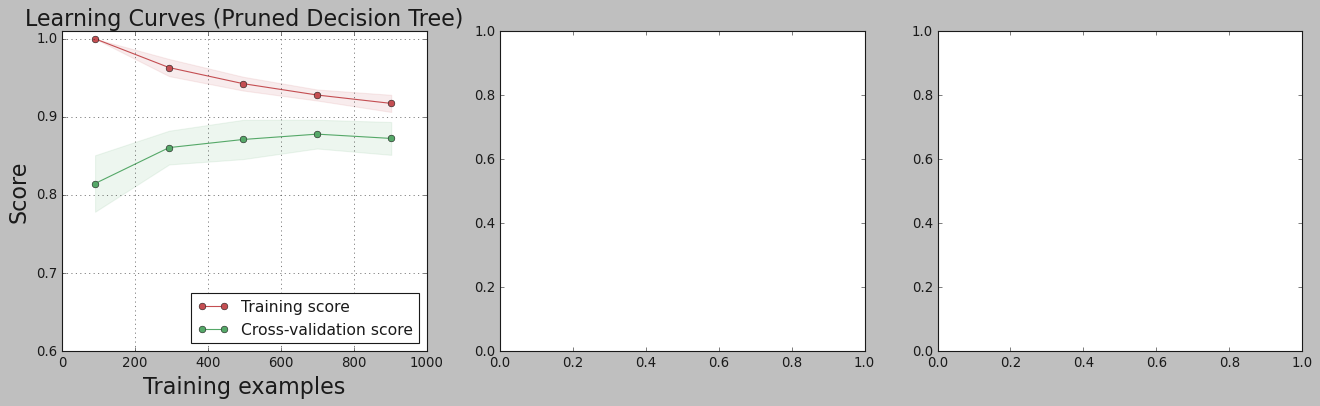

In [197]:
# Plot learning curve for decision tree classifier with post-pruning

mpl.style.use('classic')
title = "Learning Curves (Pruned Decision Tree)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = ShuffleSplit(n_splits=20, test_size=0.20, random_state=0)

estimator = best_model
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.6, 1.01),
                    cv=cv, n_jobs=4)
lc.savefig('ds2_tree_fig6', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict for decision tree is 0.828s.
Validation accuracy score post-pruning: 0.887
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       546
           1       0.89      0.89      0.89       582

    accuracy                           0.89      1128
   macro avg       0.89      0.89      0.89      1128
weighted avg       0.89      0.89      0.89      1128



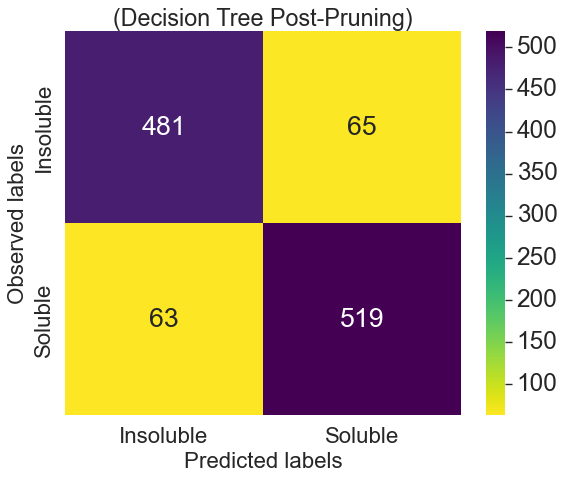

In [209]:
# Confusion matrix post pruning

estimator = best_model
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for decision tree is {}s.'.format(round(end - start, 3)))
print('Validation accuracy score post-pruning:', round(accuracy_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('(Decision Tree Post-Pruning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_tree_fig7', bbox_inches='tight')
plt.show()

## Neural Network

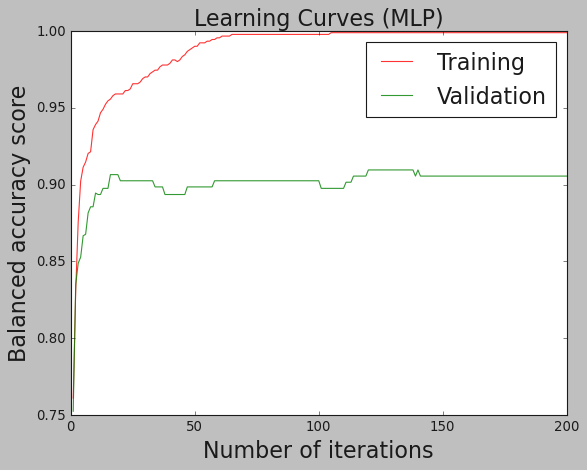

In [185]:
# Plot training/validation performance against number of iterations
mpl.style.use('classic')
estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, activation='relu', 
                    solver='adam', learning_rate_init=0.001, random_state=0)

""" Home-made mini-batch learning
"""
X_train,X_val,y_train,y_val = train_test_split(X_desc_scaled, y, test_size=0.2)
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_class = np.unique(y)
scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    #print('epoch: ', epoch)
    estimator.partial_fit(X_train, y_train, N_class)
    # SCORE TRAIN
    scores_train.append(balanced_accuracy_score(y_train, estimator.predict(X_train)))

    # SCORE TEST
    scores_test.append(balanced_accuracy_score(y_val, estimator.predict(X_val)))

    epoch += 1

iters = range(1,N_EPOCHS+1)
""" Plot """
plt.plot(iters,scores_train, color='red', alpha=0.8, label='Training')
plt.plot(iters,scores_test, color='green', alpha=0.8, label='Validation')
plt.title("Learning Curves (MLP)", fontsize=20)
plt.xlabel('Number of iterations', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.savefig('ds2_nn_fig0', bbox_inches='tight')
plt.show()

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  %

Clock time for 20-fold cross_val_predict in MLP is 2.635s.
Validation accuracy: 0.909


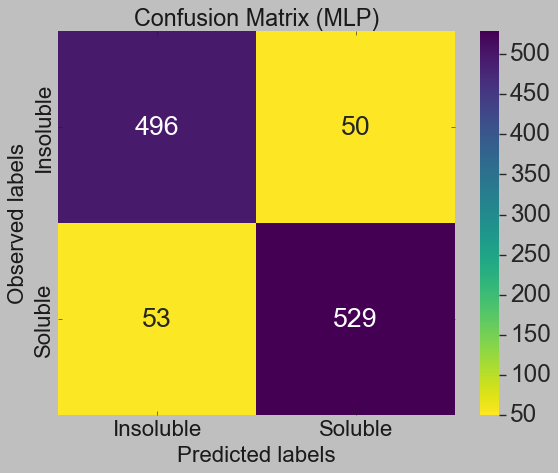

In [174]:
# Confusion matrix with default settings
mpl.style.use('classic')
estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=20, activation='relu', 
                    solver='adam', learning_rate_init=0.001, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc_scaled, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in MLP is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (MLP)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_nn_fig2', bbox_inches='tight')
plt.show()

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

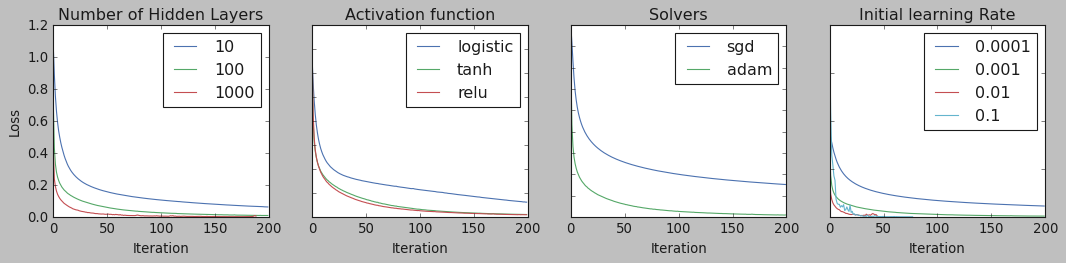

In [164]:
# MC plots: number of hidden layers, activation functions, solvers, and initial learning rates

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
sizes = [10, 100, 1000]
for s in sizes:
    mlp = MLPClassifier(random_state=0, max_iter=200, hidden_layer_sizes=s)
    mlp.fit(X_desc_scaled, y)
    axes[0].plot(mlp.loss_curve_, label='hidden_layer_size='+str(s))
axes[0].legend(sizes)
#axes[0].title('Number of Hidden Layers')

#test activation function
acts = ['logistic', 'tanh', 'relu']
for a in acts:
    mlp = MLPClassifier(random_state=0, max_iter=200, activation=a)
    mlp.fit(X_desc_scaled, y)
    axes[1].plot(mlp.loss_curve_, label='a')
axes[1].legend(acts)
#axes[1].title('Activation function')

#test solvers
solvers = ['sgd','adam']
for s in solvers:
    mlp = MLPClassifier(random_state=0, max_iter=200, solver=s)
    mlp.fit(X_desc_scaled, y)
    axes[2].plot(mlp.loss_curve_, label=s)
axes[2].legend(solvers)

learn_rate_init = [0.0001, 0.001, 0.01, 0.1]
for i in learn_rate_init:
    mlp = MLPClassifier(random_state=0, max_iter=200, learning_rate_init=i)
    mlp.fit(X_desc_scaled, y)
    axes[3].plot(mlp.loss_curve_)
axes[3].legend(learn_rate_init)

#axes[2].title('Solvers')
axes[0].set_title('Number of Hidden Layers')
axes[1].set_title('Activation function')
axes[2].set_title('Solvers')
axes[3].set_title('Initial learning Rate')

for ax in axes:
    ax.set(xlabel='Iteration', ylabel='Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes:
    ax.label_outer()

plt.savefig('ds2_nn_fig3', bbox_inches='tight')

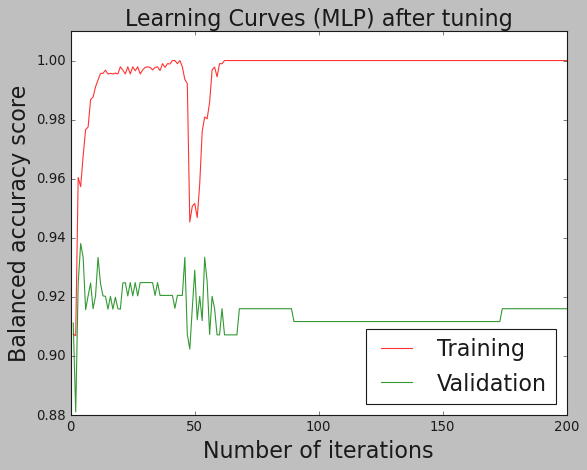

In [184]:
# Plot training/validation performance against number of iterations
mpl.style.use('classic')
estimator = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=200, activation='relu', 
                    solver='adam', learning_rate_init=0.01, random_state=0)

""" Home-made mini-batch learning
"""
X_train,X_val,y_train,y_val = train_test_split(X_desc_scaled, y, test_size=0.2)
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_class = np.unique(y)
scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    #print('epoch: ', epoch)
    estimator.partial_fit(X_train, y_train, N_class)
    # SCORE TRAIN
    scores_train.append(balanced_accuracy_score(y_train, estimator.predict(X_train)))

    # SCORE TEST
    scores_test.append(balanced_accuracy_score(y_val, estimator.predict(X_val)))

    epoch += 1

iters = range(1,N_EPOCHS+1)
""" Plot """
plt.plot(iters,scores_train, color='red', alpha=0.8, label='Training')
plt.plot(iters,scores_test, color='green', alpha=0.8, label='Validation')
plt.title("Learning Curves (MLP) after tuning", fontsize=20)
plt.xlabel('Number of iterations', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.ylim(top=1.01)
plt.legend(loc='best', fontsize=20)
plt.savefig('ds2_nn_fig6', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in MLP is 7.257s.
Validation accuracy: 0.9


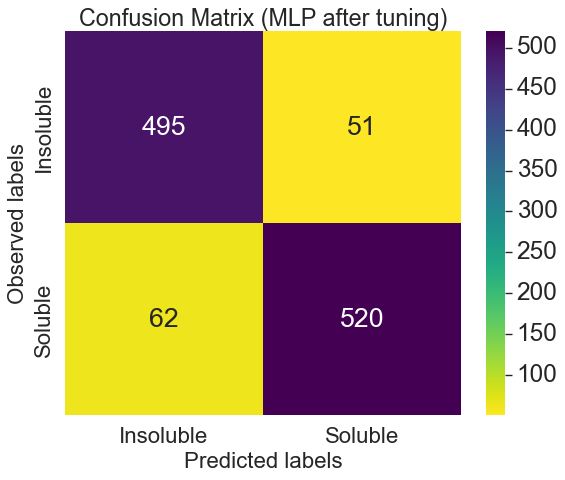

In [175]:
# Confusion matrix after tuning hyperparameters
estimator = MLPClassifier(hidden_layer_sizes=(1000,), activation='relu', solver='adam', 
                          max_iter=20, learning_rate_init=0.01, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(mlp, X_desc_scaled, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in MLP is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (MLP after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_nn_fig5', bbox_inches='tight')
plt.show()

## Boosting

Accuracy: 0.906
Fit time: 0.3737336993217468 seconds


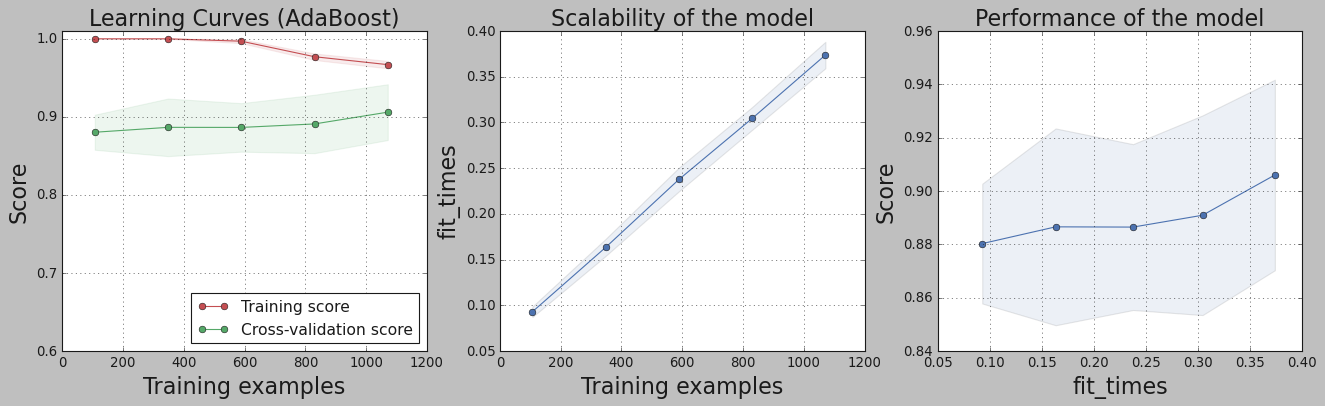

In [108]:
# Plot learning curve for AdaBoost classifier with default settings
mpl.style.use('classic')

title = "Learning Curves (AdaBoost)"

# 20-fold CV

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0)
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.6, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds2_adaboost_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 8.214s.
Validation accuracy: 0.903


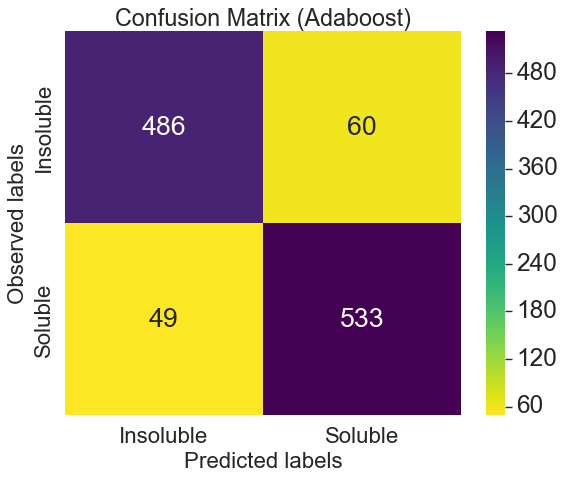

In [129]:
# Confusion matrix with default settings
estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (Adaboost)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_adaboost_fig2', bbox_inches='tight')
plt.show()

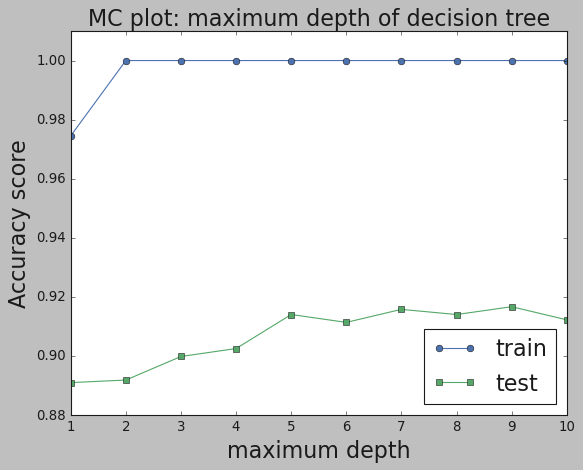

In [122]:
mpl.style.use('classic')

max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_score = []
test_score = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
X_desc = np.array(X_desc)
y = np.array(y)
kf.split(X_desc)

for d in max_depths:
    mean_train_score = 0
    mean_test_score = 0
    for train_index, test_index in kf.split(X_desc):
        estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), random_state=0)
        X_train, X_val = X_desc[train_index], X_desc[test_index]
        y_train, y_val = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_test_score += accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    test_score.append(mean_test_score / 5)
    
plt.plot(max_depths, train_score, 'o-')
plt.plot(max_depths, test_score, 's-')
plt.legend(['train', 'test'], loc='best', fontsize=20)
plt.title('MC plot: maximum depth of decision tree', fontsize=20)
plt.xlabel('maximum depth', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.ylim(top=1.01)
plt.savefig('ds2_adaboost_fig3', bbox_inches='tight')

In [125]:
test_score

[0.8953824975417894,
 0.8528416912487709,
 0.8528377581120944,
 0.8484011799410031,
 0.8484011799410031,
 0.7740648967551622]

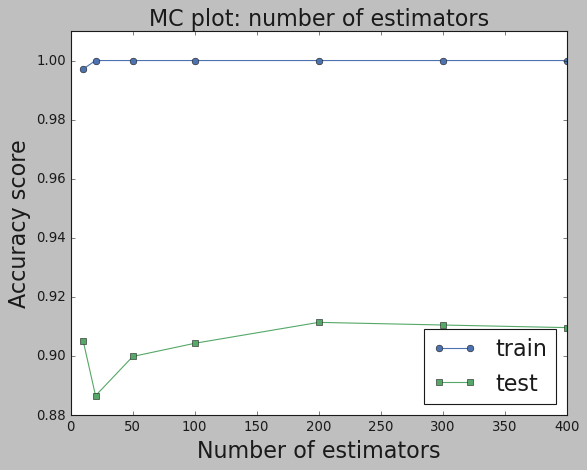

In [121]:
mpl.style.use('classic')

kf = KFold(n_splits=5, shuffle=True, random_state=0)
n_estimators = [10, 20, 50, 100, 200, 300, 400]
train_score = []
test_score = []

for e in n_estimators:
    mean_train_score = 0
    mean_test_score = 0
    for train_index, test_index in kf.split(X_desc):
        estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=e, random_state=0)
        X_train, X_val = X_desc[train_index], X_desc[test_index]
        y_train, y_val = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_test_score += accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    test_score.append(mean_test_score / 5)
    
plt.plot(n_estimators, train_score, 'o-')
plt.plot(n_estimators, test_score, 's-')
plt.legend(['train', 'test'], loc='best', fontsize=20)
plt.title('MC plot: number of estimators', fontsize=20)
plt.xlabel('Number of estimators', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.ylim(top=1.01)
plt.savefig('ds2_adaboost_fig4', bbox_inches='tight');

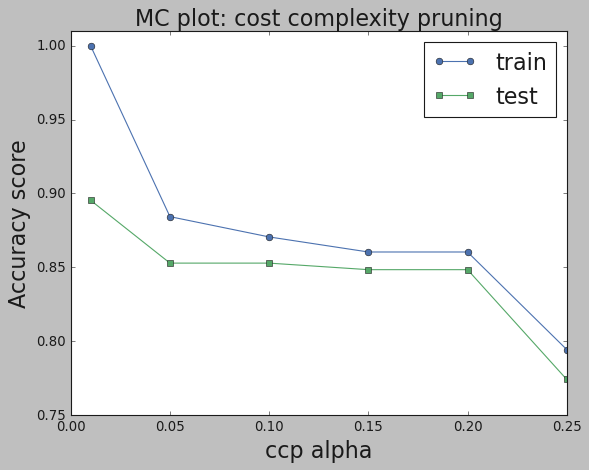

In [123]:
ccp_alphas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
train_score = []
test_score = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for a in ccp_alphas:
    mean_train_score = 0
    mean_test_score = 0
    for train_index, test_index in kf.split(X_desc):
        estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, ccp_alpha=a))
        X_train, X_val = X_desc[train_index], X_desc[test_index]
        y_train, y_val = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_test_score += accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    test_score.append(mean_test_score / 5)
    
plt.plot(ccp_alphas, train_score, 'o-')
plt.plot(ccp_alphas, test_score, 's-')
plt.legend(['train', 'test'], loc='best', fontsize=20)
plt.title('MC plot: cost complexity pruning', fontsize=20)
plt.xlabel('ccp alpha', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.ylim(top=1.01)
plt.savefig('ds2_adaboost_fig5', bbox_inches='tight');

Accuracy: 0.865


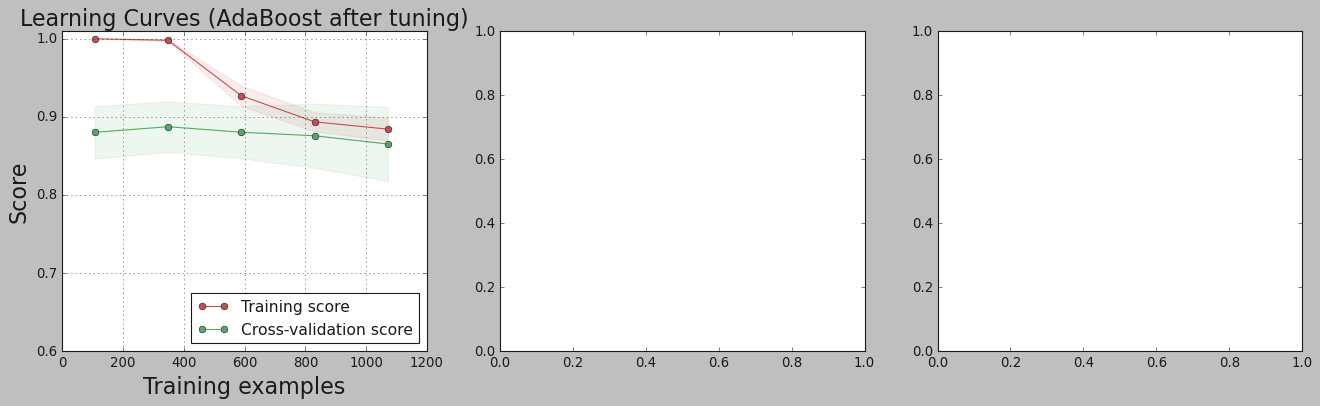

In [198]:
# Plot learning curve for AdaBoost classifier after hyperparameter tuning
mpl.style.use('classic')

title = "Learning Curves (AdaBoost after tuning)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, ccp_alpha=0.05), n_estimators=200, random_state=0)
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.6, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds2_adaboost_fig6', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 156.243s.
Validation accuracy: 0.845


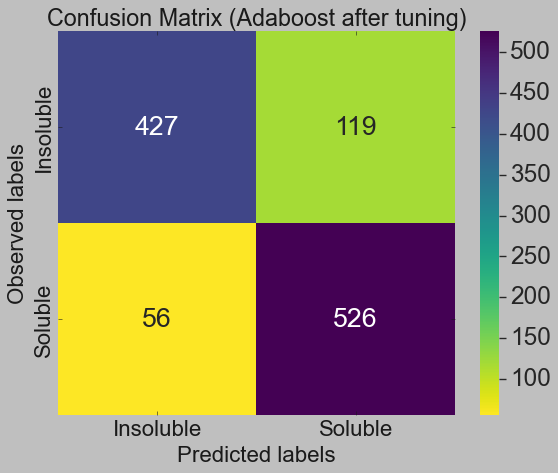

In [128]:
# Confusion matrix after tuning

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, ccp_alpha=0.05), n_estimators=200, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for AdaBoost classifier is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (Adaboost after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_adaboost_fig7', bbox_inches='tight')
plt.show()

## SVM

Accuracy: 0.83


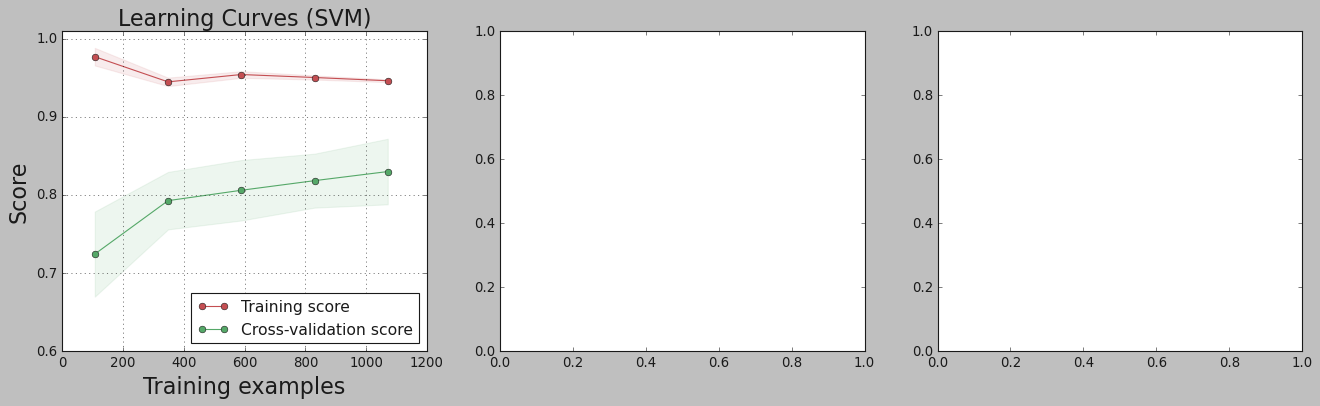

In [199]:
# Plot learning curve for support vector machine classifier with default settings and fingerprint features
mpl.style.use('classic')

title = "Learning Curves (SVM)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=0)
lc = plot_learning_curve(estimator, title, X_fp, y, ylim=(0.6, 1.01),
                    cv=20, n_jobs=4)

lc.savefig('ds2_svm_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict for SVC is 44.247s.
Validation accuracy: 0.829


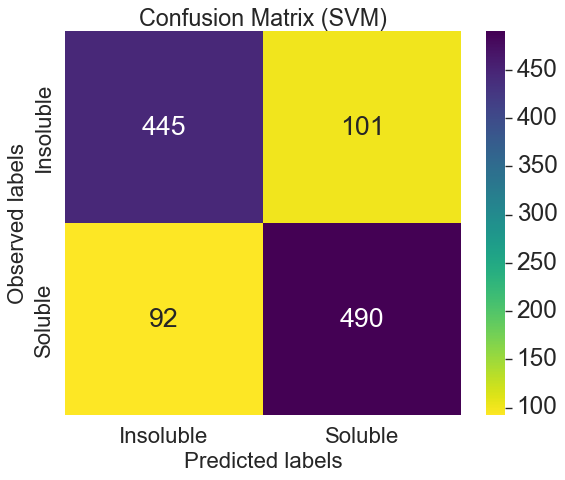

In [206]:
# Confusion matrix with default settings

estimator = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_fp, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for SVC is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (SVM)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_svm_fig2', bbox_inches='tight')
plt.show()

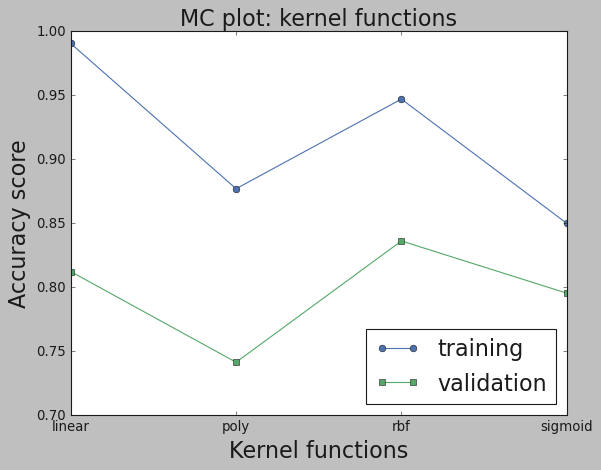

In [138]:
# MC plot: kernel functions

mpl.style.use('classic')
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kf = KFold(n_splits=5, shuffle=True)
X_fp = np.array(X_fp)
y = np.array(y)
train_score = []
val_score = []
    
for k in kernels:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_fp):
        estimator = SVC(kernel=k, degree=3, random_state=0)
        X_train, X_val = X_fp[train_index], X_fp[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    val_score.append(mean_val_score / 5)

plt.plot(kernels, train_score, 'o-')
plt.plot(kernels, val_score, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: kernel functions', fontsize=20)
plt.xlabel('Kernel functions', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.savefig('ds2_svm_fig3', bbox_inches='tight');

[0.7608619212135946, 0.8233606627821036, 0.9029239809160398, 0.9459210859097416, 0.9906920268236208, 0.9933505707754147]
[0.7243382497541788, 0.7686214355948869, 0.8111347099311702, 0.8244601769911505, 0.8244837758112095, 0.8386588003933138]


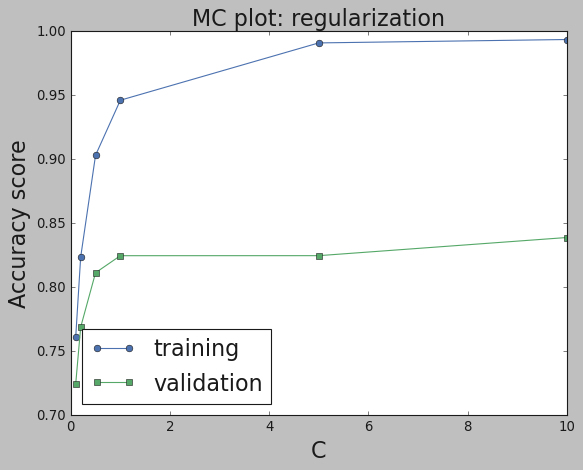

In [194]:
# MC plot: degree of the polynomial kernel function (‘poly’)
# Compare different degrees of polynomial kernel and training/test scores

mpl.style.use('classic')
C = [0.1, 0.2, 0.5, 1, 5, 10]
kf = KFold(n_splits=5, shuffle=True)
X_fp = np.array(X_fp)
y = np.array(y)
train_scores = []
val_scores = []

for c in C:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_fp):
        X_train, X_val = X_fp[train_index], X_fp[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = SVC(kernel='rbf', C=c, random_state=0)
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
print(train_scores)
print(val_scores)

plt.plot(C, train_scores, 'o-')
plt.plot(C, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: regularization', fontsize=20)
plt.xlabel('C', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.savefig('ds2_svm_fig4', bbox_inches='tight');

[0.9465875021178481, 0.5361215264221504]
[0.824495575221239, 0.5283421828908554]


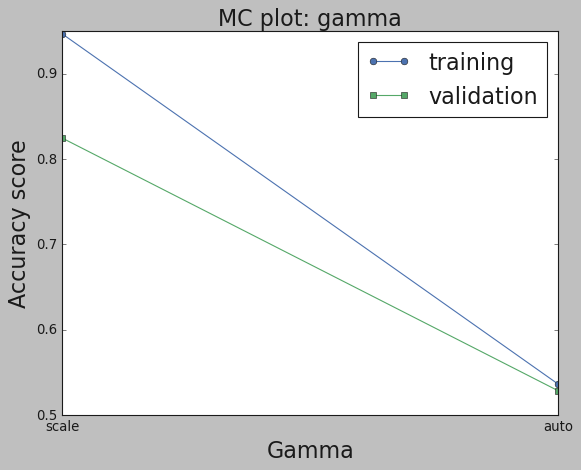

In [200]:
# MC plot: degree of the polynomial kernel function (‘poly’)
# Compare different degrees of polynomial kernel and training/test scores

mpl.style.use('classic')
gamma = ['scale', 'auto']
kf = KFold(n_splits=5, shuffle=True)
X_fp = np.array(X_fp)
y = np.array(y)
train_scores = []
val_scores = []

for g in gamma:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_fp):
        X_train, X_val = X_fp[train_index], X_fp[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = SVC(kernel='rbf', gamma=g, random_state=0)
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
print(train_scores)
print(val_scores)

plt.plot(gamma, train_scores, 'o-')
plt.plot(gamma, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: gamma', fontsize=20)
plt.xlabel('Gamma', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.savefig('ds2_svm_fig5', bbox_inches='tight');

In [192]:
estimator.get_params(deep=True)

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## k-Nearest Neighbors

Accuracy: 0.825


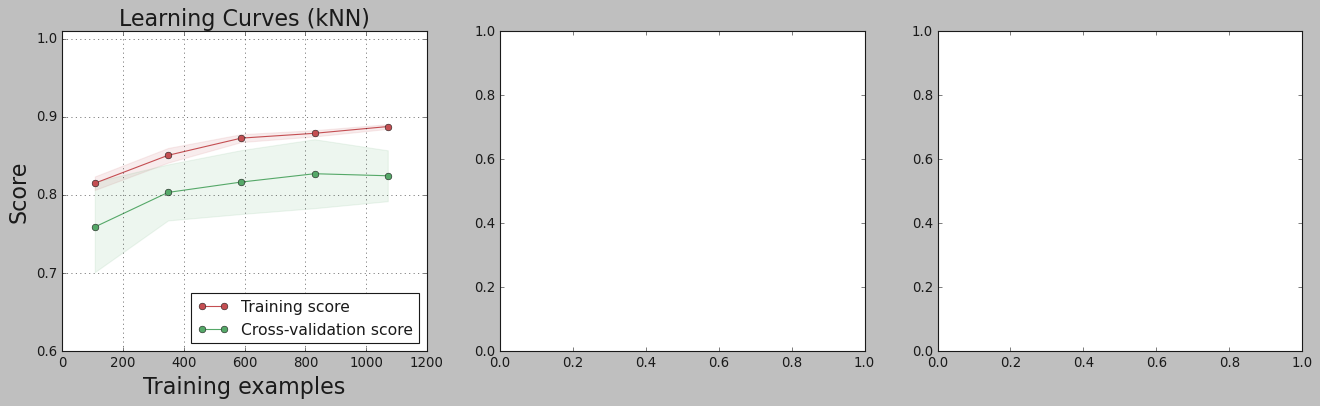

In [201]:
# Plot learning curve for support vector machine classifier with default settings
mpl.style.use('classic')
title = "Learning Curves (kNN)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = KNeighborsClassifier()
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.6, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds2_kNN_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict for kNN is 0.399s.
Validation accuracy: 0.824


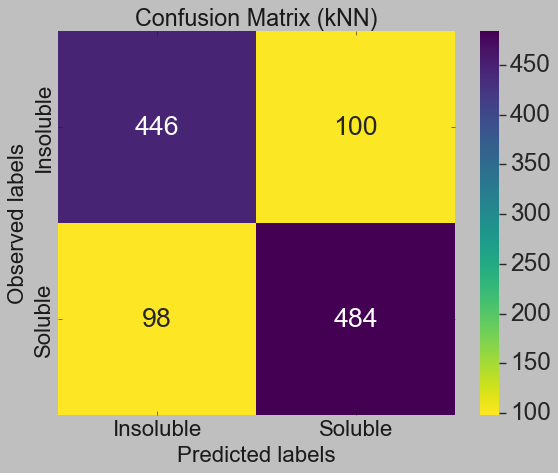

In [146]:
# Confusion matrix with default settings

estimator = KNeighborsClassifier()

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for kNN is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (kNN)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_kNN_fig2', bbox_inches='tight')
plt.show()

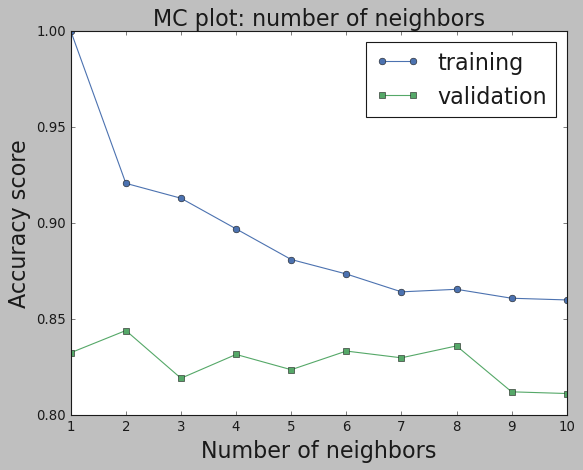

In [147]:
# MC plot: number of neighbors

mpl.style.use('classic')
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
kf = KFold(n_splits=5, shuffle=True)
X_desc = np.array(X_desc)
y = np.array(y)
train_scores = []
val_scores = []

for n in n_neighbors:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_desc):
        X_train, X_val = X_desc[train_index], X_desc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = KNeighborsClassifier(n_neighbors=n)
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
plt.plot(n_neighbors, train_scores, 'o-')
plt.plot(n_neighbors, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: number of neighbors', fontsize=20)
plt.xlabel('Number of neighbors', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.savefig('ds2_knn_fig3', bbox_inches='tight');

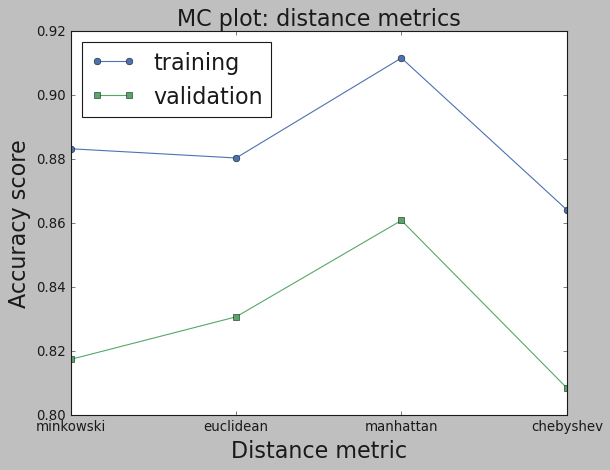

In [148]:
# MC plot: distance metrics

mpl.style.use('classic')
distance = ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
kf = KFold(n_splits=5, shuffle=True)
X_desc = np.array(X_desc)
y = np.array(y)
train_scores = []
val_scores = []

for d in distance:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_desc):
        X_train, X_val = X_desc[train_index], X_desc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = KNeighborsClassifier(metric=d)
        estimator.fit(X_train, y_train)
        mean_train_score += accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
plt.plot(distance, train_scores, 'o-')
plt.plot(distance, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: distance metrics', fontsize=20)
plt.xlabel('Distance metric', fontsize=20)
plt.ylabel('Accuracy score', fontsize=20)
plt.savefig('ds2_knn_fig4', bbox_inches='tight');

Accuracy: 0.868


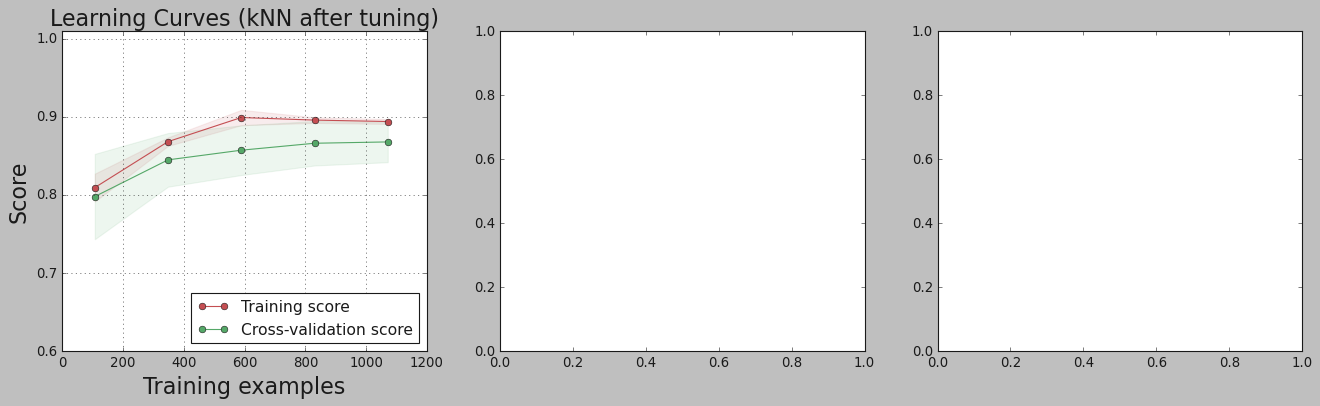

In [203]:
# Plot learning curve for support vector machine classifier after tuning

mpl.style.use('classic')
title = "Learning Curves (kNN after tuning)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = KNeighborsClassifier(n_neighbors=8, metric='manhattan')
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.6, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds2_kNN_fig5', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict for kNN is 0.435s.
Validation accuracy: 0.868


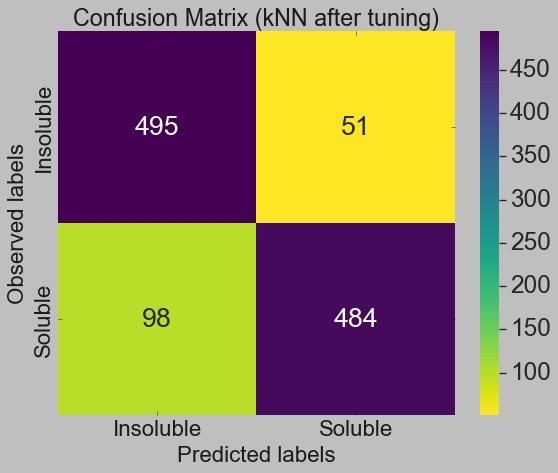

In [205]:
# Confusion matrix after tuning

estimator = KNeighborsClassifier(n_neighbors=8, metric='manhattan')

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for kNN is {}s.'.format(round(end - start, 3)))
print('Validation accuracy:', round(accuracy_score(y, predict), 3))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (kNN after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Insoluble', 'Soluble']);
ax.yaxis.set_ticklabels(['Insoluble', 'Soluble']);
plt.savefig('ds2_kNN_fig6', bbox_inches='tight')
plt.show()

In [210]:
# Final performance using molecular descriptors

accuracy = []
run_time = []
model_names = ['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
models = [DecisionTreeClassifier(ccp_alpha=0.008392210160791835, random_state=0),\
          MLPClassifier(hidden_layer_sizes=(1000,), activation='relu', solver='adam', 
                          max_iter=20, learning_rate_init=0.01, random_state=0),\
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, ccp_alpha=0.05), n_estimators=200, random_state=0),\
          SVC(kernel='rbf', gamma='scale', C=1.0, random_state=0),\
          KNeighborsClassifier(n_neighbors=8, metric='manhattan')]

for model in models:
    start = time.time()
    predict = cross_val_predict(model, X_desc, y, cv=20)
    end = time.time()
    run_time.append(end-start)
    accuracy.append(accuracy_score(y, predict))

print(model_names)
print(accuracy)
print(run_time)

df_fp = pd.DataFrame({'Model names':model_names, 'Accuracy':accuracy,\
                     'Run time':run_time})
df_fp.to_csv('./ds2_final_performance_fp_SARS_Cov-2.csv', index=False)
df_fp

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  %

['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
[0.8865248226950354, 0.7340425531914894, 0.8652482269503546, 0.5177304964539007, 0.8679078014184397]
[0.8004679679870605, 15.800731897354126, 123.73920583724976, 5.024665117263794, 0.40404605865478516]


,Model names,Accuracy,Run time
0,Decision Tree,0.886525,0.800468
1,MLP,0.734043,15.800732
2,AdaBoost,0.865248,123.739206
3,SVM,0.517730,5.024665
4,kNN,0.867908,0.404046


In [212]:
# Final performance using Morgan fingerprints

accuracy = []
run_time = []
model_names = ['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
models = [DecisionTreeClassifier(ccp_alpha=0.008392210160791835, random_state=0),\
          MLPClassifier(hidden_layer_sizes=(1000,), activation='relu', solver='adam', 
                          max_iter=20, learning_rate_init=0.01, random_state=0),\
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, ccp_alpha=0.05), n_estimators=200, random_state=0),\
          SVC(kernel='rbf', gamma='scale', C=1.0, random_state=0),\
          KNeighborsClassifier(n_neighbors=8, metric='manhattan')]

for model in models:
    start = time.time()
    predict = cross_val_predict(model, X_fp, y, cv=20)
    end = time.time()
    run_time.append(end-start)
    accuracy.append(accuracy_score(y, predict))

print(model_names)
print(accuracy)
print(run_time)

df_fp = pd.DataFrame({'Model names':model_names, 'Accuracy':accuracy,\
                     'Run time':run_time})
df_fp.to_csv('./ds2_final_performance_fp_SARS_Cov-2.csv', index=False)
df_fp

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  %

['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
[0.7154255319148937, 0.8218085106382979, 0.5159574468085106, 0.8289007092198581, 0.7624113475177305]
[2.4030890464782715, 176.23756098747253, 265.4306399822235, 43.03926181793213, 7.642183065414429]


,Model names,Accuracy,Run time
0,Decision Tree,0.715426,2.403089
1,MLP,0.821809,176.237561
2,AdaBoost,0.515957,265.430640
3,SVM,0.828901,43.039262
4,kNN,0.762411,7.642183
